In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import MissingIndicator 
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy import special

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime, date
###

import statistics
# import statsmodels.graphics.tsaplots as sgt

# from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plt.rcParams["figure.figsize"] = (18,5)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0" 

In [3]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1ZIZbKjuARboC_RdZH1ZbTS9JtmaTNFiF', sep=',')
df = df[['Date', 'Cierre']]

df = df.reindex(index = df.index[::-1])  
Fch = np.array(df['Date'])
for idx in range(0,len(Fch)):
    tmp = Fch[idx]
    Fch[idx] = datetime.strptime(tmp,"%d/%m/%Y")
 
df['Fecha'] = pd.DataFrame(Fch)

df = df.set_index('Fecha')
df = df.drop(columns='Date')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4417 entries, 2021-12-06 to 2005-01-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cierre  4417 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


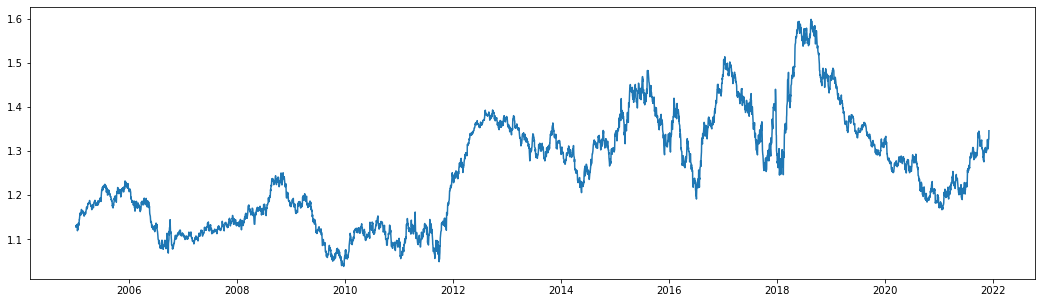

In [5]:
plt.plot(df['Cierre'])
plt.show()

In [6]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Cierre']).reshape(-1,1))

In [7]:
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
training_size

2871

In [11]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [12]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [14]:
X_train.shape, y_train.shape

((2770, 100), (2770,))

In [15]:
X_test.shape, y_test.shape

((1445, 100), (1445,))

In [49]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
# y_train = y_train.reshape(2770,1)
# y_test = y_test.reshape(y_test.shape[0],1)

In [17]:
X_train.shape, y_train.shape

((2770, 100, 1), (2770,))

In [18]:
X_test.shape, y_test.shape

((1445, 100, 1), (1445,))

In [133]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [30]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [50]:
np.random.seed(42)
tf.random.set_seed(42)

# model = keras.models.Sequential([
#     keras.layers.LSTM(20, return_sequences=True, input_shape=[100, 1]),
#     keras.layers.LSTM(20, return_sequences=True),
#     keras.layers.TimeDistributed(keras.layers.Dense(10))
# ])

# model.compile(loss="mse", optimizer="adam")
#history = model.fit(X_train, y_train, epochs=20)

model=Sequential()
model.add(LSTM(20,return_sequences=True,input_shape=(100,1)))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))



Epoch 1/20
87/87 [==============================] - 19s 176ms/step - loss: 0.1406 - last_time_step_mse: 0.1303 - val_loss: 0.0136 - val_last_time_step_mse: 0.0124
Epoch 2/20
87/87 [==============================] - 17s 199ms/step - loss: 0.0182 - last_time_step_mse: 0.0041 - val_loss: 0.0094 - val_last_time_step_mse: 0.0072
Epoch 3/20
87/87 [==============================] - 16s 178ms/step - loss: 0.0168 - last_time_step_mse: 0.0028 - val_loss: 0.0073 - val_last_time_step_mse: 0.0046
Epoch 4/20
87/87 [==============================] - 16s 186ms/step - loss: 0.0159 - last_time_step_mse: 0.0024 - val_loss: 0.0063 - val_last_time_step_mse: 0.0032
Epoch 5/20
87/87 [==============================] - 16s 187ms/step - loss: 0.0149 - last_time_step_mse: 0.0018 - val_loss: 0.0060 - val_last_time_step_mse: 0.0028
Epoch 6/20
87/87 [==============================] - 17s 198ms/step - loss: 0.0141 - last_time_step_mse: 0.0019 - val_loss: 0.0047 - val_last_time_step_mse: 0.0014
Epoch 7/20
87/87 [====

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 20)           1760      
_________________________________________________________________
dense (Dense)                (None, 100, 1)            21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


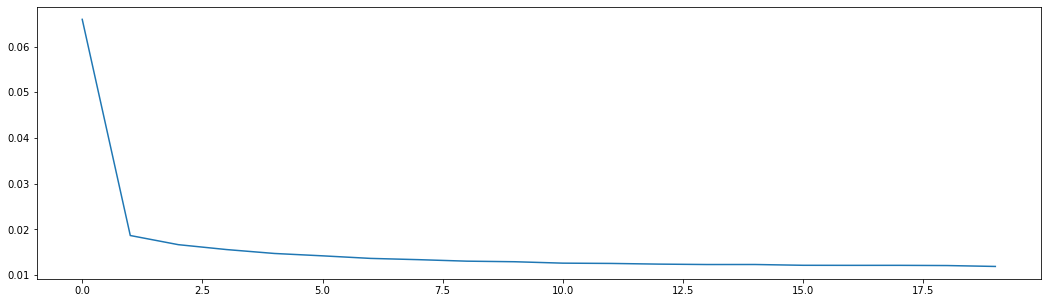

In [51]:
loss = model.history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss)
plt.show()

In [52]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [57]:
train_predict.shape, test_predict.shape

((2770, 100, 1), (1445, 100, 1))

In [56]:
train_predict_2 = train_predict
test_predict_2 = test_predict

In [46]:
train_predict = np.squeeze(X_train, axis=2)

print(X_train.shape)






SyntaxError: invalid syntax (3171207808.py, line 1)

In [37]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [6]:
# data = pd.read_csv('/home/camilocorredor/Documents/Data_Science_Projects/Euro_Dolar/Data/Data_USD_2.csv', sep = ',')
# ##data['Date'] = data['Date'].apply(lambda x: pd.Timestamp(x))
# data.set_index('Date', inplace = True)
# data = data.drop(columns=['Unnamed: 0'])
# data.head(5)